
# Genetikus algoritmusok – **Mutációs módszerek** (HU)

A legfontosabb mutációs módszerek megismerése: bináris, valós, permutációs és fa/szabály alapú kódolás.

**Fő üzenetek:**
- A mutáció **ritka**, de **elengedhetetlen** (tipikusan p≈0.01…0.1).
- Célja a **diverzitás fenntartása** és a **korai konvergencia** megelőzése – nem (csak) a gyors optimum.
- Az **utódnak mindig érvényes** megoldásnak kell maradnia.



## 1) Miért van szükség mutációra az EA-ban?

- **Feltárás:** új genetikai variációk – segít eljutni a jobb régiókhoz.  
- **Diverzitás:** védi a populációt a **korai konvergenciától**.  
- **Menekülés lokális optimumokból:** kis véletlen „lökések” új irányokba.  
- **Ritka, de fontos:** tipikusan **p≈0.01–0.1/gen** (kódolástól és feladattól függ).


In [10]:

import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
from sympy import symbols

random.seed(42)
np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)

def show_bits(title, before, after):
    # Egyszerű hőtérkép jellegű megjelenítés bitláncokra (külön ábra).
    A = np.vstack([before, after])
    plt.figure()
    plt.imshow(A, aspect='auto', interpolation='nearest')
    plt.colorbar(label="Bit (0/1)")
    plt.yticks([0,1], ["Eredeti", "Mutált"])
    plt.xticks(range(len(before)), range(len(before)))
    plt.title(title)
    plt.tight_layout()
    plt.show()

def show_vector_scatter(title, before, after):
    # 1D/2D vektorok egyszerű megjelenítése (külön ábra).
    before = np.asarray(before)
    after  = np.asarray(after)
    plt.figure()
    if before.ndim == 1:
        # 1D: x tengely index, y érték
        plt.plot(before, marker='o', label='Eredeti')
        plt.plot(after,  marker='x', label='Mutált')
        plt.xlabel("Index"); plt.ylabel("Érték")
    else:
        # 2D: csak az első két dimenziót mutatjuk
        plt.scatter(before[:,0], before[:,1], label='Eredeti')
        plt.scatter(after[:,0],  after[:,1],  label='Mutált')
        plt.xlabel("dim 1"); plt.ylabel("dim 2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def show_perm(title, before, after):
    # Permutációk vizuális összehasonlítása (rács, külön ábra).
    labels = ["Eredeti", "Mutált"]
    data = [before, after]
    plt.figure(figsize=(min(12, 0.8*len(before)+2), 2.5))
    for row, seq in enumerate(data):
        for col, v in enumerate(seq):
            plt.text(col+0.5, row+0.5, str(v), ha='center', va='center')
            plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=False))
    plt.xlim(0, len(before))
    plt.ylim(0, len(data))
    plt.yticks(np.arange(0.5, len(data)+0.5), labels)
    plt.xticks(np.arange(0.5, len(before)+0.5), range(1, len(before)+1))
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



## 2) Bináris mutációk

- **Bit flip:** 0↔1 véletlenül, valószínűséggel p.  
- **Inverzió (bit invert):** egy szegmens összes bitjét megfordítjuk.  
- **Random reset:** kiválasztott bitek új, **véletlen** értéket kapnak (0 vagy 1).


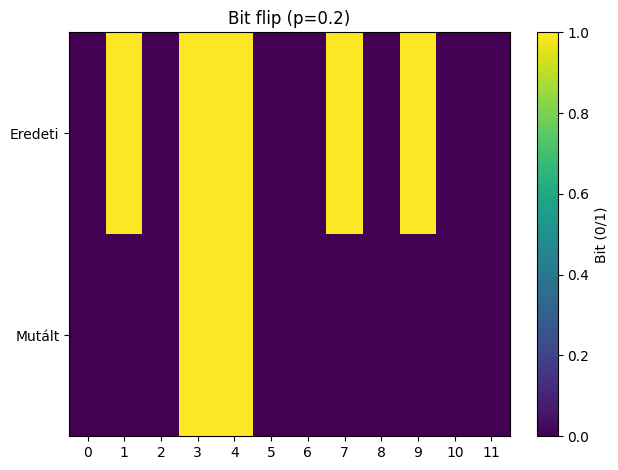

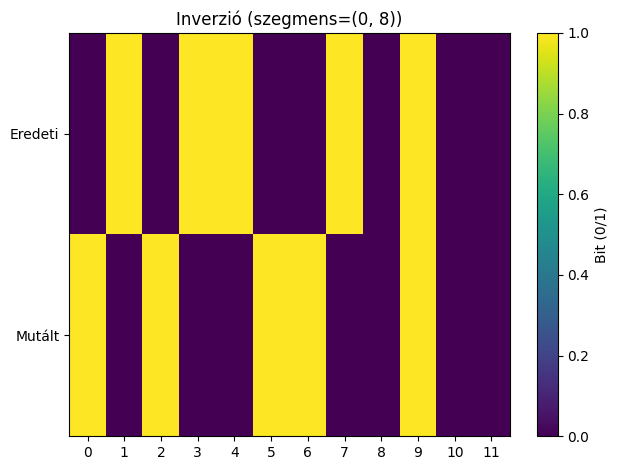

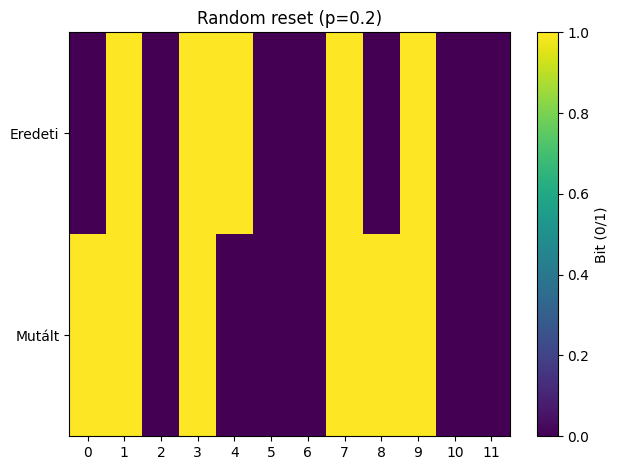

In [8]:

def bit_flip(bits, p=0.1):
    arr = bits[:]
    for i in range(len(arr)):
        if random.random() < p:
            arr[i] = 1 - arr[i]
    return arr

def bit_segment_invert(bits, i=None, j=None):
    arr = bits[:]
    if i is None or j is None:
        i, j = sorted(random.sample(range(len(arr)), 2))
    for k in range(i, j):
        arr[k] = 1 - arr[k]
    return arr, (i, j)

def bit_random_reset(bits, p=0.1):
    arr = bits[:]
    for i in range(len(arr)):
        if random.random() < p:
            arr[i] = random.randint(0,1)
    return arr

# Demo
b = [0,1,0,1,1,0,0,1,0,1,0,0]
bf = bit_flip(b, p=0.2)
show_bits("Bit flip (p=0.2)", b, bf)

bi, seg = bit_segment_invert(b, None, None)
show_bits(f"Inverzió (szegmens={seg})", b, bi)

br = bit_random_reset(b, p=0.2)
show_bits("Random reset (p=0.2)", b, br)



## 3) Valós kódolású mutációk (Bónusz)

- **Uniform perturbáció:** (Bónusz)
- **Non-uniform mutáció:** zaj amplitúdója generációval **csökken** (Bónusz)
- **Polinomiális mutáció (Deb):** eloszlásfüggő változtatás, **η** paraméterrel. (Bónusz)



## 4) Permutációs mutációk

- **Swap:** két pozíció felcserélése  
- **Insertion:** egy elem kivétele → más helyre beszúrás  
- **Inversion:** egy szegmens megfordítása  
- **Scramble:** egy szegmens elemeinek véletlen újrarendezése  

**Miért speciális?** Az utódnak **érvényes permutáció** marad: minden elem pontosan egyszer szerepel.


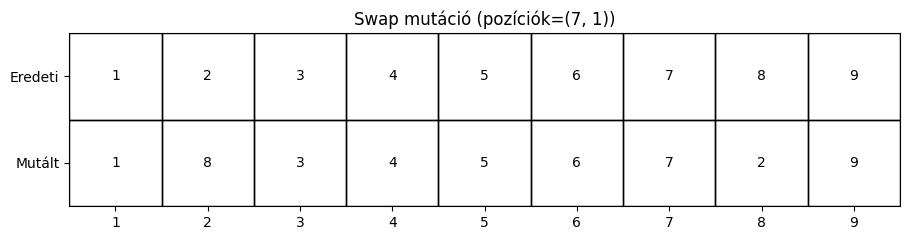

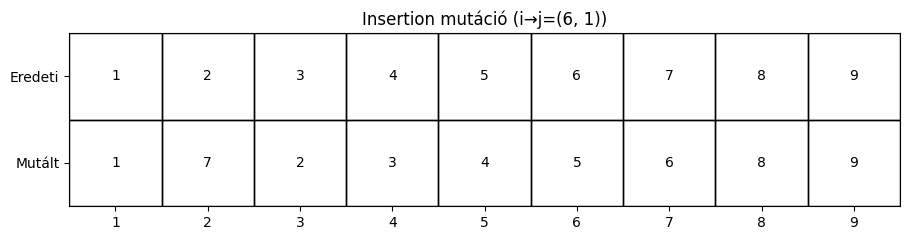

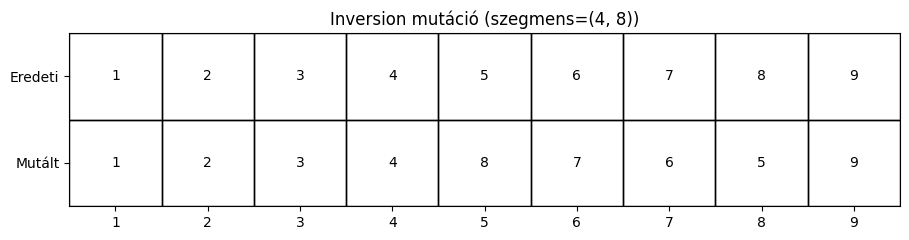

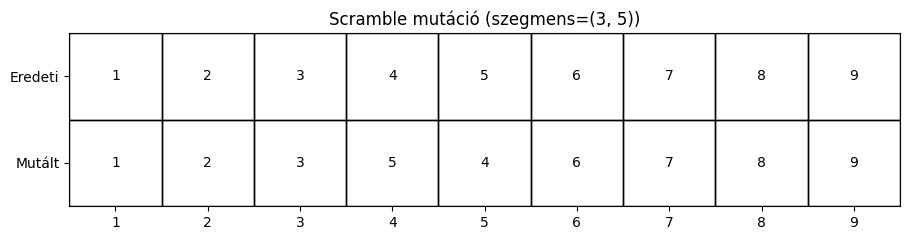

In [9]:

def swap_mutation(p):
    q = p[:]
    i, j = random.sample(range(len(q)), 2)
    q[i], q[j] = q[j], q[i]
    return q, (i, j)

def insertion_mutation(p):
    q = p[:]
    i, j = random.sample(range(len(q)), 2)
    v = q.pop(i)
    q.insert(j, v)
    return q, (i, j)

def inversion_mutation_perm(p):
    q = p[:]
    i, j = sorted(random.sample(range(len(q)), 2))
    q[i:j] = list(reversed(q[i:j]))
    return q, (i, j)

def scramble_mutation(p):
    q = p[:]
    i, j = sorted(random.sample(range(len(q)), 2))
    seg = q[i:j]
    random.shuffle(seg)
    q[i:j] = seg
    return q, (i, j)

def show_perm(title, before, after):
    labels = ["Eredeti", "Mutált"]
    data = [before, after]
    plt.figure(figsize=(min(12, 0.8*len(before)+2), 2.5))
    for row, seq in enumerate(data):
        for col, v in enumerate(seq):
            plt.text(col+0.5, row+0.5, str(v), ha='center', va='center')
            plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=False))
    plt.xlim(0, len(before))
    plt.ylim(0, len(data))
    plt.yticks(np.arange(0.5, len(data)+0.5), labels)
    plt.xticks(np.arange(0.5, len(before)+0.5), range(1, len(before)+1))
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Demo
perm = [1,2,3,4,5,6,7,8,9]
q, pos = swap_mutation(perm)
show_perm(f"Swap mutáció (pozíciók={pos})", perm, q)

q, pos = insertion_mutation(perm)
show_perm(f"Insertion mutáció (i→j={pos})", perm, q)

q, pos = inversion_mutation_perm(perm)
show_perm(f"Inversion mutáció (szegmens={pos})", perm, q)

q, pos = scramble_mutation(perm)
show_perm(f"Scramble mutáció (szegmens={pos})", perm, q)



## 5) Fa-, gráf- és szabályalapú mutációk (Bónusz)

- **Subtree mutáció:** véletlen részfa cseréje egy új, véletlen részfára.  
- **Node mutáció:** operátor/operandus lecserélése.  
- **Élek hozzáadása/törlése (gráf):** topológia módosítása.  
- **Csúcs paraméterek módosítása:** node attribútumok változtatása.  
- **Szabály módosítása / új szabály beszúrása:** szabálylisták frissítése.



## 6) Kérdések – rövid, magyar válaszok

**Miért van szükség mutációra az EA-ban?**  
A **diverzitás** fenntartásához és a **feltáráshoz**, hogy elkerüljük a korai beragadást.

**Hogyan működik a bit flip mutáció?**  
Minden bitet kis valószínűséggel (p) megfordítunk: 0↔1. Általában **ritka** (p≈0.01–0.1).

**Miért speciális a mutáció permutációs ábrázolásoknál?**  
Az utódnak **érvényes permutációt** kell adnia (minden elem egyszer). Ezért swap/insertion/inversion/scramble típusú, **sorrendmegőrző** operátorokat használunk.

**Miért kell alacsony mutációs rátát alkalmazni?**  
A túl nagy ráta **szétrombolja** a hasznos struktúrákat; a mutáció célja a **finom feltárás**, nem az azonnali megoldás.



## 7) Összegző táblázat

| Típus | Módszer(ek) | Jellemző | Előny | Hátrány | Megjegyzés |
|---|---|---|---|---|---|
| Bináris | Bit flip, Inverzió, Random reset | Diszkrét | Egyszerű | Információvesztés lehet | p≈0.01–0.1 |
| Valós | Gauss, Uniform, Non-uniform, Polinomiális | Folytonos | Finoman hangolható | Paraméterérzékeny | σ, ε, η |
| Permutáció | Swap, Insertion, Inversion, Scramble | Kombinatórikus | Érvényes utód | Lokális módosítás | Sorrend megtartása |
| Fa | Subtree, Node | Strukturális | Kifejező | Költséges | GP |
| Gráf | Él hozzáadás/törlés, Node paraméter | Strukturális | Topológia változtatása | Érvényesség kérdése | Heurisztikák |
| Szabály | Módosítás, Új szabály | Strukturális | Moduláris | Kontextusfüggő | Validáció |
